In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import morphs
import ephys
import ephys.clust

from pathlib2 import Path

/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
prb_blocks = {}
for block in morphs.config.paths.blocks():
    prb_files = list(Path(block).glob('*.prb'))
    assert len(prb_files) == 1
    prb_name = prb_files[0].stem.lower()
    if not prb_name in prb_blocks:
        prb_blocks[prb_name] = []
    prb_blocks[prb_name].append(block)

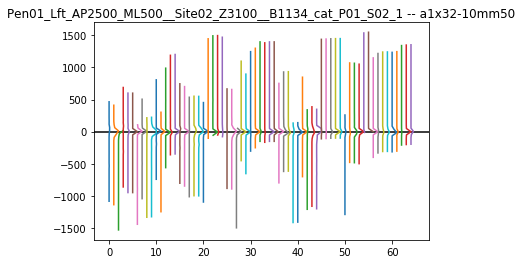

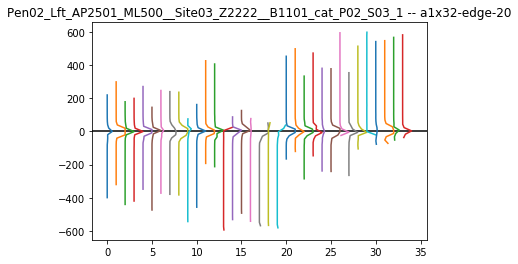

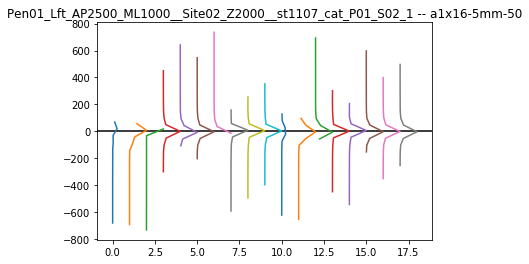

In [3]:
for probe in prb_blocks:
    for block in prb_blocks[probe]:
        spikes = morphs.data.load.ephys_data(block, collapse_endpoints=True)
        if len(spikes) == 0:
            continue
        waveforms, cluster_map = ephys.clust.compute_cluster_waveforms_fast(block, spikes)
        amps = (waveforms[:,0,:] + waveforms[:,-1,:]) / 2 - np.min(waveforms, axis=1)
        amps /= np.max(amps, axis=0)

        prb_files = list(Path(block).glob('*.prb'))
        assert len(prb_files) == 1
        prb = morphs.data.localize._read_python(prb_files[0])
        for group in prb['channel_groups']:
            chans = prb['channel_groups'][group]['geometry'].keys()
            x, y = zip(*[prb['channel_groups'][group]['geometry'][k] for k in chans])

            idxs = np.argsort(y)
            y = np.array(y)[idxs]
            plt.figure()
            plt.axhline(0, color='k')
            for clust in xrange(amps.shape[0]):
                temp = amps[clust,idxs] ** 2
                y_hat = np.sum(temp * y) / np.sum(temp)
                l = plt.plot(temp + clust, y - y_hat)
            plt.title(' -- '.join([morphs.data.parse.blockpath_name(block), probe]))
        break

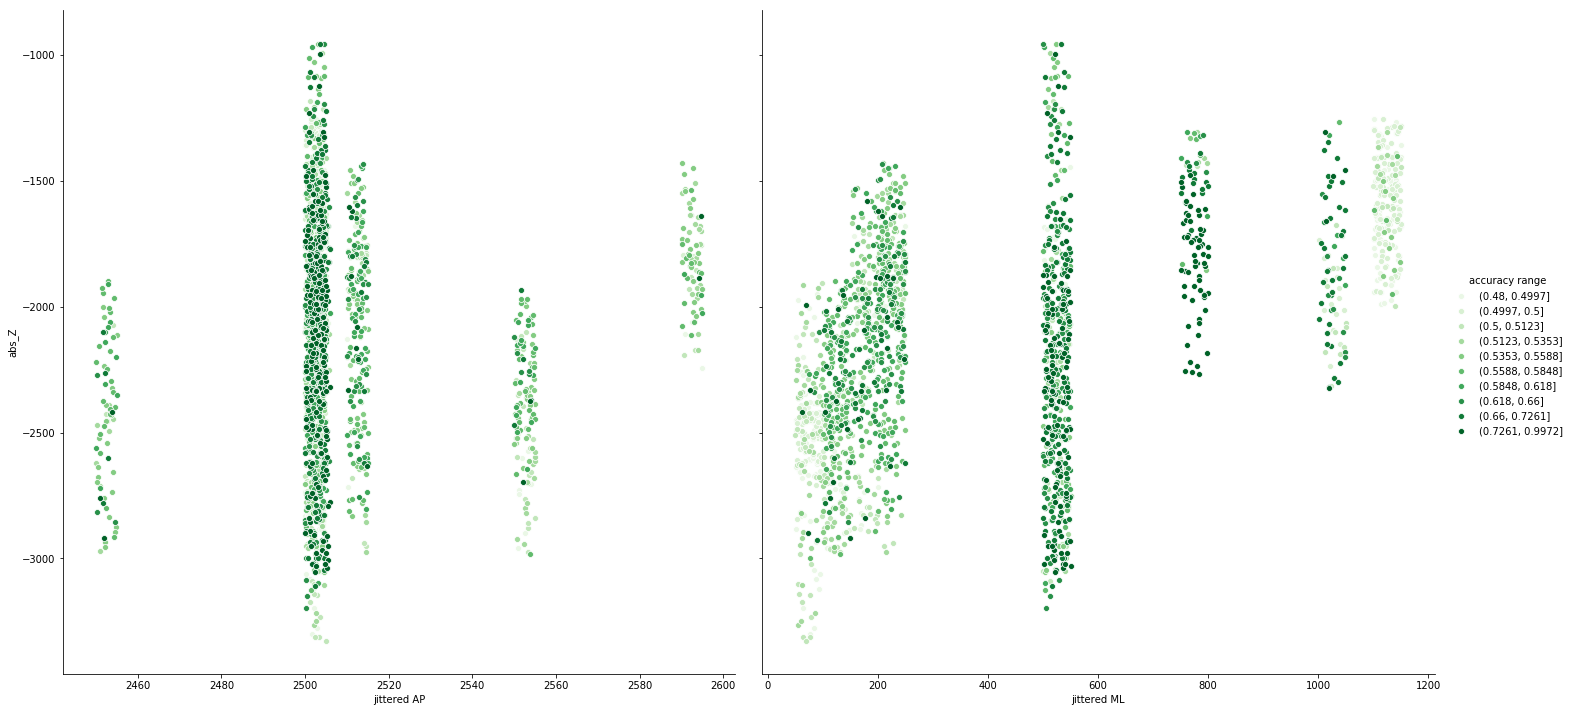

In [4]:
all_loc = morphs.data.load.all_loc()

all_loc['abs_Z'] = all_loc['cluster_pos'] - all_loc['Z']

all_loc['accuracy range'] = pd.qcut(all_loc['cluster_accuracy'], 10)

all_loc['jittered AP'] = all_loc['AP'] + 5 * np.random.random(len(all_loc))
all_loc['jittered ML'] = all_loc['ML'] + 50 * np.random.random(len(all_loc))

g = sns.pairplot(all_loc, hue='accuracy range', 
                 x_vars=['jittered AP', 'jittered ML'], 
                 y_vars=['abs_Z'], kind='scatter', 
                 height=10, palette='Greens')